In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import plotly_express as px

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [3]:
listings = pd.read_csv("https://raw.githubusercontent.com/alvaro99dd/Analisis-AirBnB-Sydney/main/Recursos\listings_clean.zip")
listings.head()

id                                           name  \
0  1050164598350388320                 Self service English breakfast   
1  1096082243192434668                   Apartment in Rushcutters Bay   
2              2167538            Modern Sydney home near beach,shops   
3   790607305500629830                             Luxury double room   
4   641106357139201992  Chic Studio Apartment in Prime Bondi Location   

     host_id  host_name neighbourhood   latitude   longitude        room_type  \
0  211218678       Paul    Botany Bay -33.924060  151.197320     Private room   
1   26721338       Anne        Sydney -33.874830  151.225800  Entire home/apt   
2   11059668     Sophie      Waverley -33.895820  151.245490  Entire home/apt   
3  202112801     Vivian    Canada Bay -33.851626  151.086324     Private room   
4  279001183  MadeComfy      Waverley -33.890550  151.275230  Entire home/apt   

   price  price_eur  ...  review_scores_checkin  review_scores_rating  \
0  100.0      62.00  ...                    NaN                   NaN   
1  250.0     155.00  ...                    NaN                   NaN   
2  650.0     403.00  ...                   5.00                  4.00   
3   84.0      52.08  ...                   4.81                  4.71   
4  508.0     314.96  ...                   3.71                  4.00   

  maximum_nights                                       listing_url  \
0            365  https://www.airbnb.com/rooms/1050164598350388320   
1            365  https://www.airbnb.com/rooms/1096082243192434668   
2           1125              https://www.airbnb.com/rooms/2167538   
3            365   https://www.airbnb.com/rooms/790607305500629830   
4            365   https://www.airbnb.com/rooms/641106357139201992   

   host_is_superhost                                         host_about  \
0                  f                                                NaN   
1                  f  J'aime voyager, lire, le sport (taekwondo, rando)   
2                  f  Hi, I am Sophie. We love our house and share m...   
3                  f                                                NaN   
4                  f  Hi, and welcome to MadeComfy!\n\nWe are a team...   

   host_response_time host_response_rate bedrooms  beds  
0  a few days or more               20.0      1.0   1.0  
1      within an hour              100.0      2.0   2.0  
2        within a day              100.0      3.0   3.0  
3      within an hour               99.0      1.0   1.0  
4                 NaN                NaN      1.0   1.0  

[5 rows x 37 columns]

In [4]:
def clean_outliers(df_aux, column: str):
    Q1 = df_aux[column].quantile(0.25)
    Q3 = df_aux[column].quantile(0.75)
    IQR = Q3 - Q1
    df_aux = df_aux[(df_aux[column] >= Q1-1.5*IQR) & (df_aux[column] <= Q3 + 1.5*IQR)]
    return df_aux

### Gráfico Precio Medio por Tipo de propiedad

In [5]:
# Calcular la media del precio por tipo de propiedad
mean_price = listings.groupby('property_type')['price_eur'].mean().round(2).sort_values(ascending=False).head(10)
# Colores
colors = ['#FF3131' if i < 1 else '#36454F' for i in range(len(mean_price))]

fig = px.bar(mean_price, x=mean_price.index, y=mean_price.values, labels={'y':'Precio Medio', 'property_type':'Tipo de Propiedad'})
fig.update_layout(
    xaxis_title='Tipo de Propiedad',
    yaxis_title='Precio Medio',
    title='Precio Medio por Tipo de Propiedad'
)
fig.update_traces(marker_color=colors)
fig.show()

### Distribución todas las Valoraciones, Valoracion total y Precio

In [6]:
fig = px.scatter(listings, x='review_scores_rating', y='number_of_reviews', color="price_eur",
                size="number_of_reviews", range_color=[0, 500], range_x=[4, 5],
                title="Distribución todas las Reviews, Valoración Total y Precio",
                labels={"review_scores_rating": "Valoración Total", "number_of_reviews": "Total Reviews", "price_eur": "Precio(€)"},)
fig.show()

### Distribución Numero de propiedades por total de comodidades y Precio Medio 

In [7]:
df_aux = listings.copy()
df_aux['total_amenities'] = df_aux['amenities'].apply(lambda x: len(x.split(',')) if x != '[]' else 0)

mean_price_amenities=df_aux.groupby('total_amenities')['price_eur'].mean().round(2).reset_index(name='mean_price')
count_properties_amenities = df_aux.groupby('total_amenities')['price_eur'].count().reset_index(name='count_properties')

result_df = pd.merge(mean_price_amenities, count_properties_amenities, on='total_amenities')

fig = px.scatter(result_df, x='total_amenities', y='count_properties', color="mean_price", size="count_properties", title='Numero de propiedades por total de comodidades', range_color=[0, 500],
                labels={'mean_price': 'Precio Medio(€)', 'count_properties': 'Numero de propiedades', 'total_amenities': 'Total de comodidades'})
fig.update_layout(
    xaxis_title='Total de comodidades',
    yaxis_title='Numero de propiedades',
    title='Numero de propiedades por total de comodidades',
)
fig.show()

In [8]:
listings['neighbourhood'].value_counts(ascending=False).head(10)

Sydney              2988
Waverley            1319
Pittwater            901
Randwick             813
Warringah            758
Manly                651
North Sydney         575
Woollahra            449
Sutherland Shire     393
Marrickville         387
Name: neighbourhood, dtype: int64

### Grafico barras Precio Medio(€) por número de Habitaciones con el Top 5 Tipos de Propiedad

In [9]:
df_aux = listings.copy()
grouped_df = df_aux.groupby(['bedrooms', 'property_type']).agg(
    price_eur_mean=('price_eur', 'mean')
).reset_index()

top_5_property_types = df_aux['property_type'].value_counts().nlargest().index

filtered_grouped_df = grouped_df[grouped_df['property_type'].isin(top_5_property_types)]


final_filtered_df = filtered_grouped_df[(filtered_grouped_df['bedrooms'] >= 1)&(filtered_grouped_df['bedrooms'] <= 10)]
fig = px.bar(final_filtered_df,
            x="bedrooms",
            y="price_eur_mean",
            color="property_type",
            barmode="group",
            title="Precio Medio(€) por Número de Habitaciones con el Top 5 Tipos de Propiedad",
            labels={"bedrooms": "Número de Habitaciones", "price_eur_mean": "Precio Medio (EUR)", "property_type": "Tipo de propiedad"},
            category_orders={"bedrooms": sorted(final_filtered_df['bedrooms'].unique())})  # Ordenar las categorías de 'bedrooms'

fig.update_layout(
    plot_bgcolor="white",
    yaxis=dict(title='Precio Medio (EUR)', gridcolor='lightgrey'),
    xaxis=dict(title='Número de Habitaciones'),
    legend=dict(title='Tipo de Propiedad')
)
fig.show()

### Mapa Propiedades por Precio que tengan mas de 10 Reseñas

In [10]:
df_filtered = listings.copy()
df_filtered['review_scores_rating'] = listings[listings["number_of_reviews"] > 10]["review_scores_rating"]

df_filtered = df_filtered.dropna(subset=["review_scores_rating"])
df_filtered = df_filtered.sort_values(by="review_scores_rating", ascending=True)
df_filtered['adjusted_size'] = df_filtered['price_eur'] + 35

fig = px.scatter_mapbox(df_filtered, lat="latitude", lon="longitude",
                        color="price_eur", size="adjusted_size",
                        size_max=55, 
                        animation_frame="review_scores_rating",
                        zoom=9, mapbox_style="open-street-map",
                        width=1200, height=800,
                        color_continuous_scale="viridis",
                        title="Propiedades por Precio que tengan mas de 10 Reseñas", range_color=[0, 500],
                        labels={"price_eur": "Precio (EUR)", "review_scores_rating": "Valoración Total"})


fig.show()

### TreeMap Distribución de Precio Medio por Barrio

In [11]:
listings_clean_df = listings.copy()

listings_clean_df.dropna(subset=['neighbourhood', 'price_eur'], inplace=True)

price_mean_by_neighbourhood = listings_clean_df.groupby('neighbourhood', as_index=False)['price_eur'].mean().round(2)
price_mean_by_neighbourhood.rename(columns={'price_eur': 'price_mean_eur'}, inplace=True)

fig = px.treemap(price_mean_by_neighbourhood, 
                path=['neighbourhood'], 
                values='price_mean_eur',
                color='price_mean_eur', 
                color_continuous_scale='RdYlGn',
                title='Distribución de Precio Medio por Barrio',
                labels={'price_mean_eur': 'Precio Medio (€)'})
fig.update_traces(hovertemplate='Barrio: %{label}<br>Precio Medio (€): %{value}')
fig.show()

## Vecindario

### Nº de propiedades por vecindario

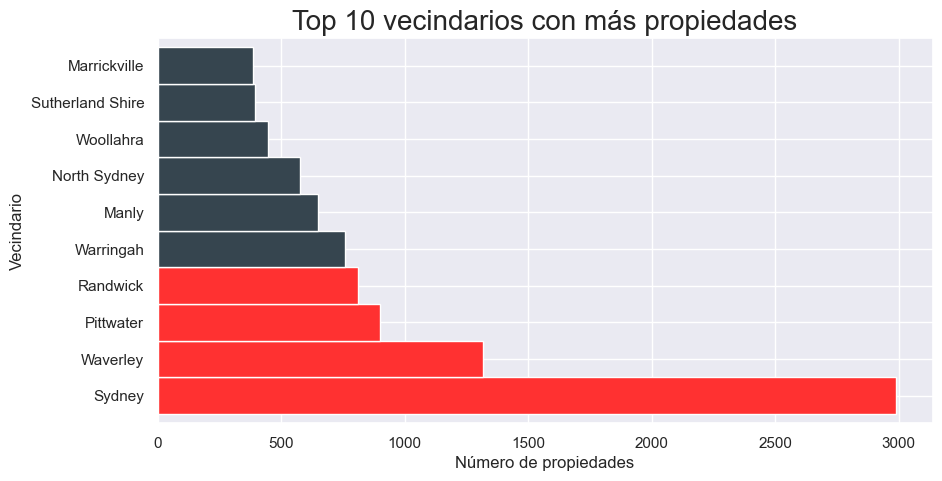

In [12]:
feq=listings['neighbourhood'].value_counts(ascending=False).head(10) # Calculamos el top 10 de vecindarios con más propiedades
colors = ['#FF3131' if i < 4 else '#36454F' for i in range(len(feq))] # Destacamos el top 4
# Creamos y mostramos el gráfico
fig = feq.plot.barh(figsize=(10, 5), color=colors, width=1, subplots=True)
plt.title("Top 10 vecindarios con más propiedades", fontsize=20)
plt.xlabel('Número de propiedades', fontsize=12)
plt.ylabel('Vecindario', fontsize=12)
plt.show()

#### Tipo de habitaciones según el top 4 de vecindarios

In [13]:
# Mostramos un gráfico con el top 4 de vecindarios con más propiedades
fig = px.histogram(listings, x=listings['neighbourhood'], color=listings['room_type'], color_discrete_map={'Entire home/apt': '#5DADE2', 'Private room': '#239B56', 'Shared room': '#A6ACAF', "Hotel room" : "#BB8FCE"}
                    , title='Distribución de tipos de habitaciones por vecindario', labels={'neighbourhood': 'Vecindario', 'room_type': 'Tipo de habitación'})
fig.update_layout(barmode='group', legend=dict(orientation="h", y=1.12, x=0, xanchor='left')) # Ajustamos la leyenda y el modo de ver las barras, para hacer una mejor comparación
fig.update_xaxes(categoryorder='total descending', range=(-.5, 3.5)) # Ordenamos los vecindarios de mayor a menor y mostramos el top 4
fig.update_yaxes(title='Número de propiedades')
fig.show()

#### Tipo de propiedades según el top 4 de vecindarios

In [14]:
# Creamos un dataframe auxiliar con el top 4 visto anteriormente
df_aux = listings[(listings['neighbourhood'] == "Sydney") | (listings['neighbourhood'] == "Waverley") | (listings['neighbourhood'] == "Pittwater") | (listings['neighbourhood'] == "Randwick")]
# Mostramos la figura con el top 4 de vecindarios y tipos de propiedades
fig = px.histogram(df_aux, x=df_aux['neighbourhood'], color=df_aux['property_type']
                    , title='Distribución de tipos de propiedades por vecindario', labels={'neighbourhood': 'Vecindario', 'property_type': 'Tipo de propiedad'})
fig.update_layout(barmode='group')
fig.update_xaxes(categoryorder='total descending', range=(-.5, 3.5))
fig.update_yaxes(title='Número de propiedades')
fig.show()

In [15]:
calendar_data = pd.read_csv("https://raw.githubusercontent.com/alvaro99dd/Analisis-AirBnB-Sydney/main/Recursos\calendar.zip", low_memory=False)
calendar_data = pd.merge(listings, calendar_data, left_on="id", right_on="listing_id", how="left")
calendar_data = calendar_data.groupby(["neighbourhood", "date"])["available"].value_counts().unstack()

In [16]:
calendar_data["available_ratio"] = np.round(calendar_data["t"] / (calendar_data["t"] + calendar_data["f"]) * 100, 2)
calendar_data = calendar_data.reset_index()
calendar_data

available neighbourhood        date      f      t  available_ratio
0              Ashfield  2024-03-16   14.0    2.0            12.50
1              Ashfield  2024-03-17    9.0    7.0            43.75
2              Ashfield  2024-03-18   78.0   27.0            25.71
3              Ashfield  2024-03-19   70.0   35.0            33.33
4              Ashfield  2024-03-20   73.0   32.0            30.48
...                 ...         ...    ...    ...              ...
13941         Woollahra  2025-03-13  282.0  167.0            37.19
13942         Woollahra  2025-03-14  281.0  168.0            37.42
13943         Woollahra  2025-03-15  280.0  169.0            37.64
13944         Woollahra  2025-03-16  244.0  160.0            39.60
13945         Woollahra  2025-03-17  245.0  159.0            39.36

[13946 rows x 5 columns]

In [17]:
calendar_data = clean_outliers(calendar_data, "available_ratio")

In [18]:
calendar_data = calendar_data[(calendar_data['neighbourhood'] == "Sydney") | (calendar_data['neighbourhood'] == "Waverley") | (calendar_data['neighbourhood'] == "Pittwater") | (calendar_data['neighbourhood'] == "Randwick")]
px.scatter(calendar_data, x= "date", y="available_ratio", title="Disponibilidad de propiedades por vecindario"
            , color="neighbourhood"
            , labels={"available_ratio": "Ratio de disponibilidad", "date": "Fecha", "neighbourhood": "Vecindario"})

### Mapa de propiedades en Sydney

In [19]:
# Creamos una lista con las latitudes y longitudes de las propiedades en Sydney
lats2018 = listings['latitude'].tolist()
lons2018 = listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

# Creamos y mostramos el mapa con esas propiedades, ajustando la posición a Sydney
map1 = folium.Map(location=[-33.86785, 151.20732], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

In [20]:
df_aux = listings.copy() # Creamos un datafarme auxiliar copiando el contenido de listings
df_aux["other_rooms"] = df_aux["room_type"] # Creamos una nueva columna con el mismo contenido que la columna room_type
# Iteramos sobre room_type para cambiar los valores diferentes de Entire home/apt por Other rooms
for i in range(len(df_aux["room_type"])):
    if (df_aux.at[i, "other_rooms"] == "Shared room") or (df_aux.at[i, "other_rooms"] == "Hotel room") or (df_aux.at[i, "other_rooms"] == "Private room"):
        df_aux.at[i, "other_rooms"] = "Other rooms"

In [21]:
df_aux["top4_neighbourhoods"] = df_aux[(df_aux["neighbourhood"] == "Sydney") | (df_aux["neighbourhood"] == "Waverley") | (df_aux["neighbourhood"] == "Pittwater") | (df_aux["neighbourhood"] == "Randwick")]["neighbourhood"]
# Con los datos anteriores, creamos un mapa interactivo con las propiedades de tipo Entire home/apt y Other rooms
fig = px.scatter_mapbox(df_aux, lat='latitude', lon='longitude', color='other_rooms', zoom=10
                        , mapbox_style='open-street-map'
                        , opacity=0.7
                        , title='Distribución de los tipos de vivienda en los cuatro barrios más populares de Sydney'
                        , labels={'room_type': 'Tipo de habitación', "other_rooms": "Clasificación", "latitude": "Latitud", "longitude": "Longitud", "price_eur": "Precio en euros", "top4_neighbourhoods": "Vecindario"}
                        , hover_data={"other_rooms": False, "top4_neighbourhoods": False, "room_type":True, "price_eur": True}
                        , color_discrete_map={'Entire home/apt': '#36454F', 'Other rooms': '#FF3131'}
                        , animation_frame="top4_neighbourhoods"
                        , width=1200, height=800)
fig.update_layout(legend=dict(orientation="h", y=1.06, x=0, xanchor='left'))
fig.show()

### Relaciones con la puntuación de ubicación

#### Precio medio según las puntuaciones de ubicación

In [22]:
# Usando el dataframe auxiliar anterior, eliminamos sus outliers para mostrar un gráfico más preciso
df_aux = clean_outliers(df_aux, "price_eur")
# Creamos una columna nueva donde tendremos sólo las reviews de las propiedades con más de 10 reviews
df_aux["real_reviews_location"] = df_aux[df_aux["number_of_reviews"] > 10]["review_scores_location"]

In [23]:
# colors = ['#FF3131' if i >= 87 else '#36454F' for i in range(len(df_aux["real_reviews_location"]))]
# Destacamos las propiedades que tienen una puntuación mayor o igual a 4.9
df_aux['color_condition'] = df_aux['real_reviews_location'].apply(lambda x: 'Mayor o igual a 4.9' if x >= 4.9 else 'Menor a 4.9')
# Mostramos el histograma con el precio medio por puntuación de ubicación
fig = px.histogram(df_aux, x="real_reviews_location", y="price_eur"
                    , range_y=[0,500], range_x=[3.5,5], histfunc="avg"
                    , title="Precio medio por puntuación de ubicación"
                    , labels={'real_reviews_location': 'Puntuación de ubicación', 'price_eur': 'Precio en euros'}
                    , color='color_condition'
                    , color_discrete_map={'Mayor o igual a 4.9': '#FF3131', 'Menor a 4.9': '#36454F'} # Mapeo de colores
                    , hover_data={"color_condition": False})  # Ocultamos la información de color_condition en el hover
fig.update_layout(showlegend=False)
fig.show()

#### Top 4 vecindarios con más puntuación de localización

In [24]:
df_aux['color'] = df_aux['neighbourhood'].apply(lambda x: "#FF3131" if x in ["Randwick", "Sydney"] else "#36454F") # Destacamos los vecindarios Randwick y Sydney
# Mostramos un boxplot con el top 4 vecindarios con más puntuación de ubicación, destacando Randwick y Sydney ya que pertenecen a los 4 vecindarios con más propiedades
fig = px.box(df_aux, x="real_reviews_location", y="neighbourhood"
                    , range_x=[4,5]
                    , title="Top 4 vecindarios con más puntuación de ubicación"
                    , labels={'real_reviews_location': 'Puntuación de ubicación', 'price_eur': 'Precio en euros', "neighbourhood": "Vecindario"}
                    , orientation="h"
                    , color='color'
                    , color_discrete_map="identity")
fig.update_yaxes(categoryorder='total descending', range=(-.5, 3.5))
fig.update_traces(width=0.7, boxmean=True)
fig.show()
df_aux.drop(columns=["color"], inplace=True)

## Seguridad en los vecindarios

### Fuente: https://crimetool.bocsar.nsw.gov.au/bocsar/

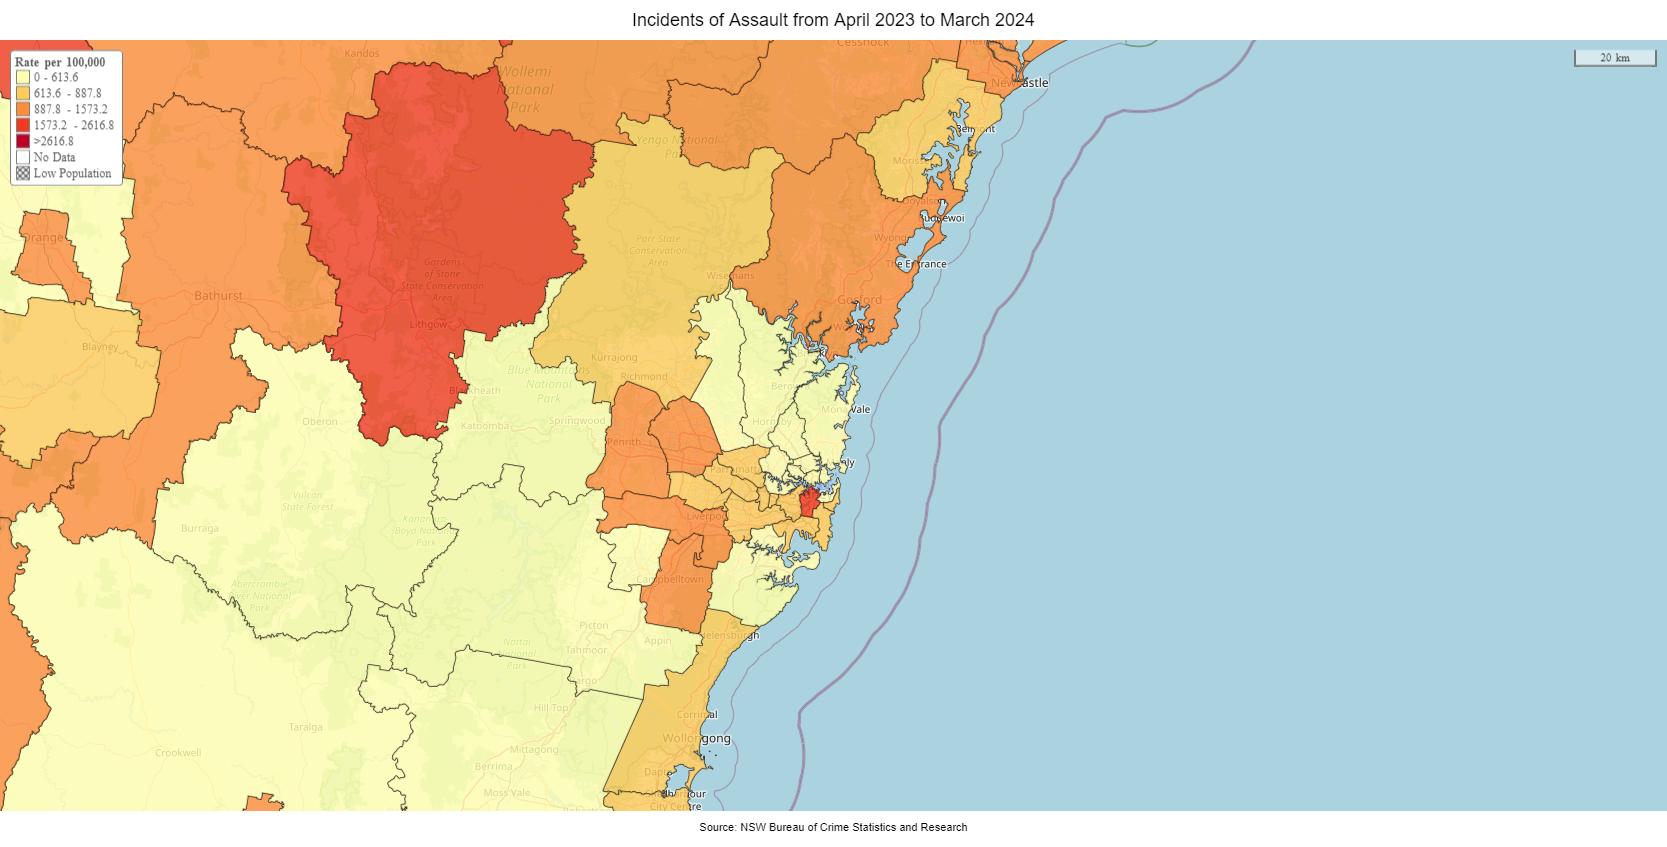

In [25]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/alvaro99dd/Analisis-AirBnB-Sydney/main/Recursos\Incidents of Assault from April 2023 to March 2024 Rate.png")